In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Camera Specifications
FOV = 63.75
N_x = 80
N_y = 60
focal_length = 1.3669e-3
pixel_size   = 17e-6
angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
radians_per_pixel = np.radians(angles_per_pixel)
print(angles_per_pixel, radians_per_pixel)
# Camera Constants
const = pixel_size/focal_length
FOV_x = radians_per_pixel * N_x
FOV_y = radians_per_pixel * N_y
print(np.degrees(FOV_x), np.degrees(FOV_y))

# Frame Specification
height   = 6500.       # Troposhere Height
epsilon  = 40         # Sun elevation Angle
epsilon  = np.radians(epsilon)
altitude = 1630        # Albuquerque Height above sea-level
r_earth  = 6371000.    # Average Earth radius
r = r_earth + altitude # Earth radious in albuquerque
# Sun's Position on the Cartenian Coordiantes
x_sun_ = [30, 40]
X_, Y_ = np.meshgrid(np.linspace(0., N_x - 1, N_x), np.linspace(0., N_y - 1, N_y))
print(X_.shape, Y_.shape)

# Great-Circle Approach

In [9]:
def _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_, epsilon, azimuth, latitude, longitude, height, 
                                   altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
    
    # Solve Troposphere and Earth Surface Chords equation
    def __solve_quadratic_formula(W_, e_, height):
        N = e_.shape[0]
        x_ = np.zeros(N)
        y_ = np.zeros(N)
        z_ = np.zeros(N)
        # Solve quadratic formula for each elevation angle in a frame
        for i in range(N):
            x_[i] = np.roots(W_[:, i])[1]
            y_[i] = x_[i] * np.tan(e_[i])
            z_[i] = y_[i] / np.sin(e_[i])
        return x_, y_, z_
    # Compute coefficients of the Troposphere and Earth Surface Chords equation
    def __quadratic_coefficient(e_, r, height):
        N = e_.shape[0]
        # Compute quadratic formula coefficients for each elevation angle in a frame
        a_ = 1 + np.tan(e_)**2
        b_ = 2. * r * np.tan(e_)
        c  = - height * (1. + 2.*r)
        c_ = np.ones(N) * c
        return np.stack((a_, b_, c_))
    # Extend Elevation from Sun's Elevation Angle for each pixel
    def __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel):
        y_0 = x_sun_[0]
        d_0 = y_0
        d_1 = N_y - y_0
        return np.linspace(epsilon + (d_0 + 1)*radians_per_pixel, epsilon - d_1*radians_per_pixel, N_y + 1)
    # Extend azimuth from camera FOV Angle for each pixel
    def __coordiantes_azimuth(x_sun_, asimuth, N_x, radians_per_pixel):
        a_ = np.linspace(0, N_x + 1, N_x + 2)
        return np.absolute(a_ -  a_.mean())*radians_per_pixel
    
    # Project the Cross-Section plane in the Camera pLane in y-axis
    def __y_axis(x_, y_, z_, height):
        # Ciruclar Segment formula
        rho_ = height - y_
        k_ = rho_ + (x_**2)/rho_
        s_ = .5*np.arcsin(2.*x_/k_)*k_
        # compute y-axis absolute distance
        y_  = s_[1:] - s_[0]
        # Differencital distance between pixels
        dy_ = np.diff(s_)
        # Extend values to the frame dimensions grid
        dY_ = np.tile(dy_, (N_x, 1)).T
        Y_  = np.tile( y_, (N_x, 1)).T
        return Y_, dY_, s_[0]
    # Project the Cross-Section plane in the Camera pLane in x-axis
    def __x_axis(z_, azimuth_, r):
        # Quadratic formular coefficients
        def ___quadratic_coeff(dx, r):
            a = -1.
            b = 2. * r 
            c = (dx/2.)**2
            return [a, b, c]
        # Solve Quadratic formular
        def ___quadratic_solver(w_, dx):
            # Find solution for given coefficients
            l = np.roots(w_)[1]
            # Ciruclar Segment formula
            k = l + (dx**2)/(4.*l)
            s = np.arcsin(dx/k) * k
            return l, k, s
        # Compute the increments in the x-axis using the FOV in the x-axis of the camera
        def ___inc(z_, azimuth_, i, j):
            alpha = np.absolute(azimuth_[j - 1]) + np.absolute(azimuth_[-j])
            x = 2.*z_[i]*np.tan(alpha/2.)
            return x
        # Variables initialization
        N = z_.shape[0]
        M = azimuth_.shape[0]
        X_  = np.zeros((N, M))
        dX_ = np.zeros((N, M))
        # Loop over pixels
        for i in range(N):
            for j in range(1, M//2 + 1):
                # Calculate incremental differnce in the x-axis
                dx = ___inc(z_, azimuth_, i, j)
                # Quadratic formula coeffcient
                w_ = ___quadratic_coeff(dx, r)
                # Solve for given coeffcient and estimate x-axis (i,j) coordiante value
                l, k, x = ___quadratic_solver(w_, dx)
                # x-axis simetric distance 
                X_[i, j - 1] = -x/2.
                X_[i, -j]    =  x/2.
        # Compute x-axis differential pixels distance
        dx_ = np.diff(X_[:, :M//2], axis = 1)
        dX_ = np.concatenate((dx_, dx_[:, ::-1]), axis = 1)
        return X_[1:, 1:-1], dX_[1:, :]
    # Project the Cross-Section plane in the Camera pLane in distance from the Sun's potion
    def __z_axis(X_, Y_, dX_, dY_):
        # Geometric distance
        Z_  = np.sqrt( X_**2 +  Y_**2)
        # Differential ditance
        dZ_ = np.sqrt(dX_**2 + dY_**2)
        return Z_, dZ_
    # Set y-axis origen in the current position of the Sun
    def __set_origen_in_sun(X_0_, Y_0_, Z_0_, x_sun_):
        # Set y-axis
        y_0 = x_sun_[0]
        Y_0_ -= Y_0_[y_0, :]
        # Corrent distance with newly computed centered grid of the y-axis
        Z_0_ = np.sqrt(X_0_**2 + Y_0_**2)
        return X_0_, Y_0_, Z_0_
    
    # Perpendicular FOV as frame pixels limits
    def __prespective_limits(X_, Y_, Z_):
        # Set origin in the current epsilon position 
        #X_, Y_, Z_ = __set_origen_in_sun(X_, Y_, Z_, x_sun_)
        # Get the axis in the 90 degrees epsilon position 
        X_0_, Y_0_, Z_0_, dX_0_, dY_0_, dZ_0_, y_0 = __get_axes(x_sun_, epsilon = np.pi/2, azimuth = 0, height = 12500)
        # Set origin in the 90 degrees epsilon position 
        X_0_, Y_0_, Z_0_ = __set_origen_in_sun(X_0_, Y_0_, Z_0_, x_sun_)
        # Maximum distance in y-axis
        x_lim_ = X_0_[:, -1]
        # Index within the maximum distnace in x-axis
        idx_x_ = np.absolute(X_) <= np.tile(x_lim_, (N_x, 1)).T + 1
        # Maximum distance in y-axis
        y_lim_ = Y_0_[:, -1] 
        # Index within the maximum distnace in y-axis
        idx_y_ = ( Y_ < y_lim_.max() + 1) & ( Y_ > y_lim_.min() - 1 )
        return idx_x_ & idx_y_
    
    def __interpolation_grid(X_p_, Y_p_, Z_p_, dX_, dY_, dZ_):
        # Perpendicular FOV as frame pixels limits
        index_ = __prespective_limits(X_p_, Y_p_, Z_p_)
        xx_= []
        Y_ = (N_y - 1)*( Y_p_[index_] - np.min(Y_p_[index_]))/(np.max(Y_p_[index_]) - np.min(Y_p_[index_]))
        for y in np.unique(Y_p_[index_]):
            idx_ = (Y_p_ == y) & index_
            x_ = (N_x - 1)*( X_p_[idx_] - np.min(X_p_[idx_]))/(np.max(X_p_[idx_]) - np.min(X_p_[idx_]))
            xx_.append(x_)
        X_ = np.concatenate(xx_, axis = 0)
        return [np.concatenate((X_[:, np.newaxis],  Y_[:, np.newaxis]), axis = 1), index_]
    
    def __get_axes(x_sun_, epsilon, azimuth, height):
        # Set the origen of the Coordinates plane in the Sun Position in the frame
        epsilon_ = __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel)
        azimuth_ = __coordiantes_azimuth(x_sun_, azimuth, N_x, radians_per_pixel)
        # Get throposhere quadrative formulat solution coeffiencients
        W_ = __quadratic_coefficient(epsilon_, r, height)
        # Solve the quadrative formulate for the given coefficients
        x_, y_, z_ = __solve_quadratic_formula(W_, epsilon_, height)
        # Get the axis distance and differential distances
        Y_, dY_, y_0 = __y_axis(x_, y_, z_, height)
        X_, dX_ = __x_axis(z_, azimuth_, r)
        Z_, dZ_ = __z_axis(X_, Y_, dX_, dY_)
        return X_, Y_, Z_, dX_, dY_, dZ_, y_0
    
    def __rotate_grid(X_, Y_, y_0, azimuth, longitude, latitude, height, r):
        # Define Units System Transformation
        meters_per_latitude  = 110574
        meters_per_longitude = 111320*np.cos(latitude)
        # Define Scale Transformation
        rho = r / (r + height)
        # Define Rotation Transformation
        R_ = np.array([[np.cos(azimuth), -np.sin(azimuth)], [np.sin(azimuth), np.cos(azimuth)]])
        # Scale and tanslation Tranformation
        X_p_ = X_ * rho
        Y_p_ = Y_ * rho + y_0
        # Rotation Transformation
        XY_ = np.concatenate(( X_p_.flatten()[..., np.newaxis],  Y_p_.flatten()[..., np.newaxis]), axis = 1)
        XY_p_ = XY_ @ R_
        # Units Transformation from meters to degrees
        XY_pp_ = XY_p_.copy()
        XY_pp_[..., 0] = XY_p_[..., 0] / meters_per_longitude + np.degrees(longitude)
        XY_pp_[..., 1] = XY_p_[..., 1] / meters_per_latitude + np.degrees(latitude)
        return XY_, XY_p_, XY_pp_
    
    
    # Elevation Angle from Degrees to Radiantes
    epsilon = np.radians(epsilon)
    azimuth = np.radians(azimuth)
    latitude  = np.radians(latitude)
    longitude = np.radians(longitude)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    # Camera Constants
    const = pixel_size/focal_length
    alpha_y = radians_per_pixel*FOV_y/2
    # Sky-Parcel Geometric Constants
    r_earth = 6371000.     # Average Earth radius
    r = r_earth + altitude # Earth radious in albuquerque
    # Get axis in the current degrees epsilon position 
    X_, Y_, Z_, dX_, dY_, dZ_, y_0 = __get_axes(x_sun_, epsilon, azimuth, height)
    # Transform grid to project it in a GCS
    XY_, XY_p_, XY_pp_ = __rotate_grid(X_, Y_, y_0, azimuth, longitude, latitude, height, r)
    # Set origin in the current epsilon position 
    X_, Y_, Z_ = __set_origen_in_sun(X_, Y_, Z_, x_sun_)
    # Stack together the Coordinates system and the incrementes in the coordinates grid
    XYZ_  = np.concatenate(( X_[..., np.newaxis],  Y_[..., np.newaxis],  Z_[..., np.newaxis]), axis = 2)
    dXYZ_ = np.concatenate((dX_[..., np.newaxis], dY_[..., np.newaxis], dZ_[..., np.newaxis]), axis = 2)
    # Transformation of the camerea trjectory to pixels on the images
    #x_ = A_sun_.copy()
    #x_ = A_sun_
    #x_[0, :] = (x_[0, :] - x_[0, 0]) / angles_per_pixel
    #x_[1, :] = (x_[1, :] - x_[1, 0]) / angles_per_pixel
    # Get index of the epsilon 90 grid projected in the current epsilon grid
    XY_interp_ = __interpolation_grid(X_, Y_, Z_, dX_, dY_, dZ_)
    return XYZ_, dXYZ_, XY_, XY_p_, XY_pp_, XY_interp_

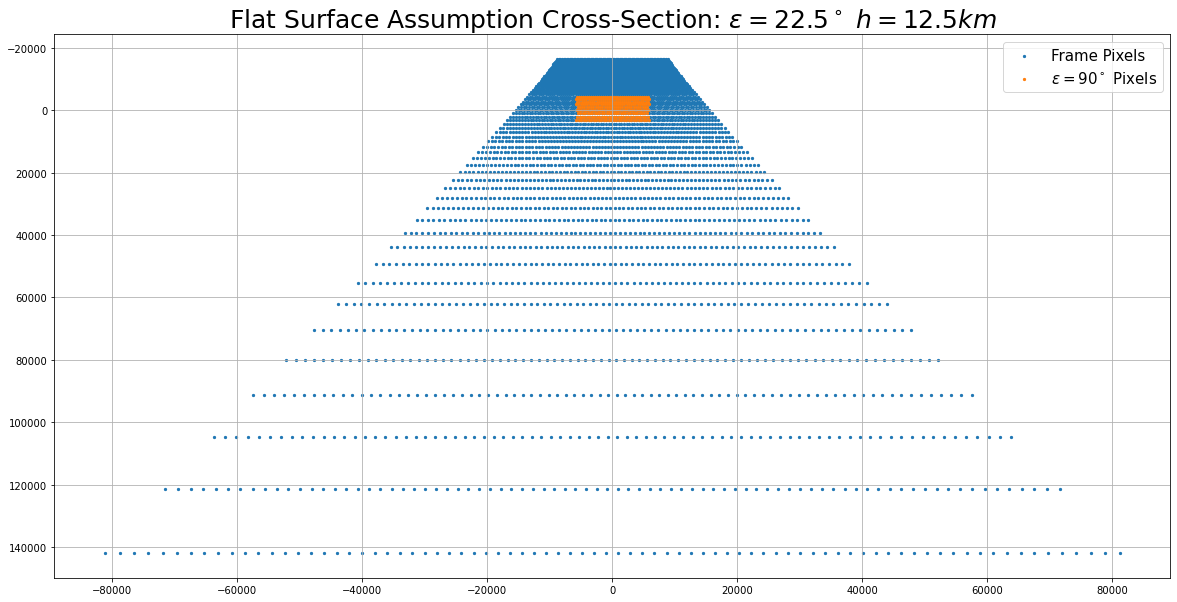

In [10]:
# ME Building Localization
latitude  = 35.082074
longitude = -106.625857
    
# Camera Parameters
epsilon = 22.5
azimuth = 100
height  = 12500.
x_sun_ = [30, 40]

XYZ_, dXYZ_, _, _, _, XY_interp_ = _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_, 
                                                         epsilon, azimuth, latitude, longitude, height)

plt.figure(figsize = (20, 10))
plt.title(r'Flat Surface Assumption Cross-Section: $ \varepsilon = {}^\circ$ $h = {} km$'.format(epsilon, height/1000), fontsize = 25)
plt.scatter(XYZ_[..., 0].flatten(), XYZ_[..., 1].flatten(), s = 5, label = 'Frame Pixels')
plt.scatter(XYZ_[XY_interp_[1], 0].flatten(), XYZ_[XY_interp_[1], 1].flatten(), s = 5, label = r'$\varepsilon = 90^\circ$ Pixels')
plt.legend(fontsize = 15)
plt.grid()
plt.gca().invert_yaxis()
plt.show()

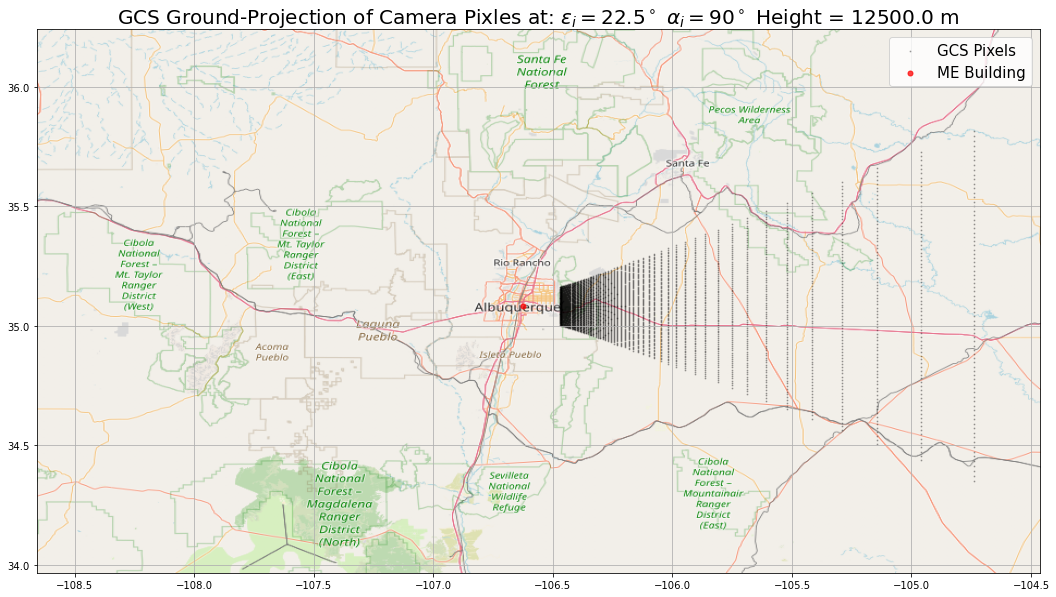

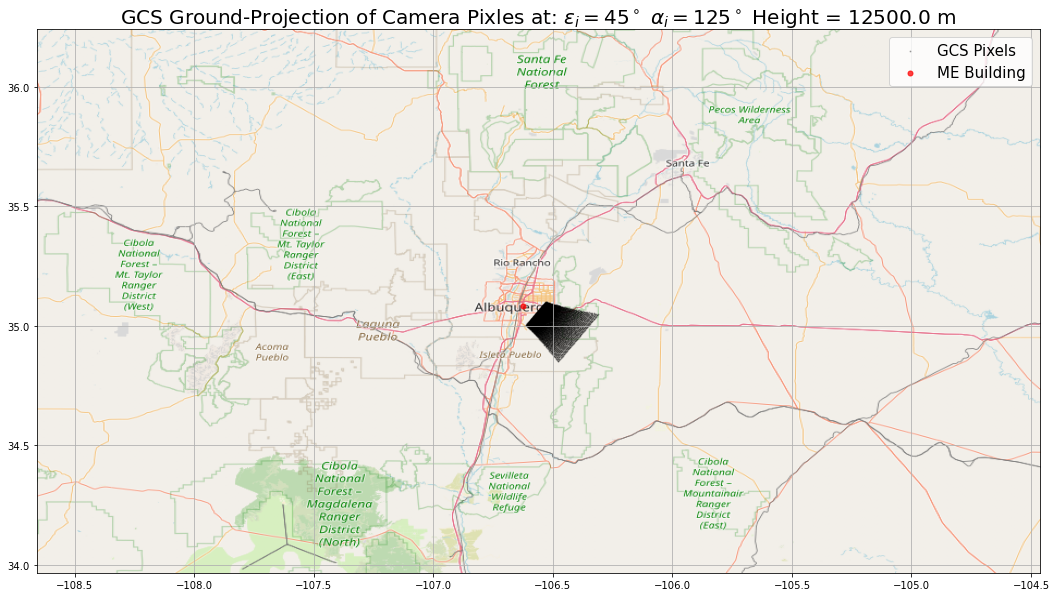

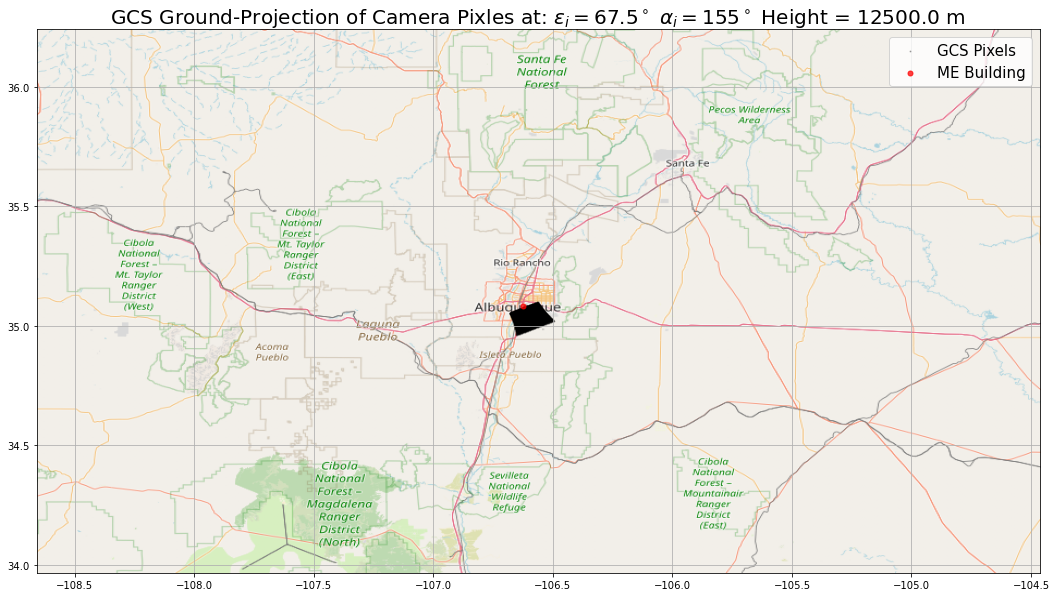

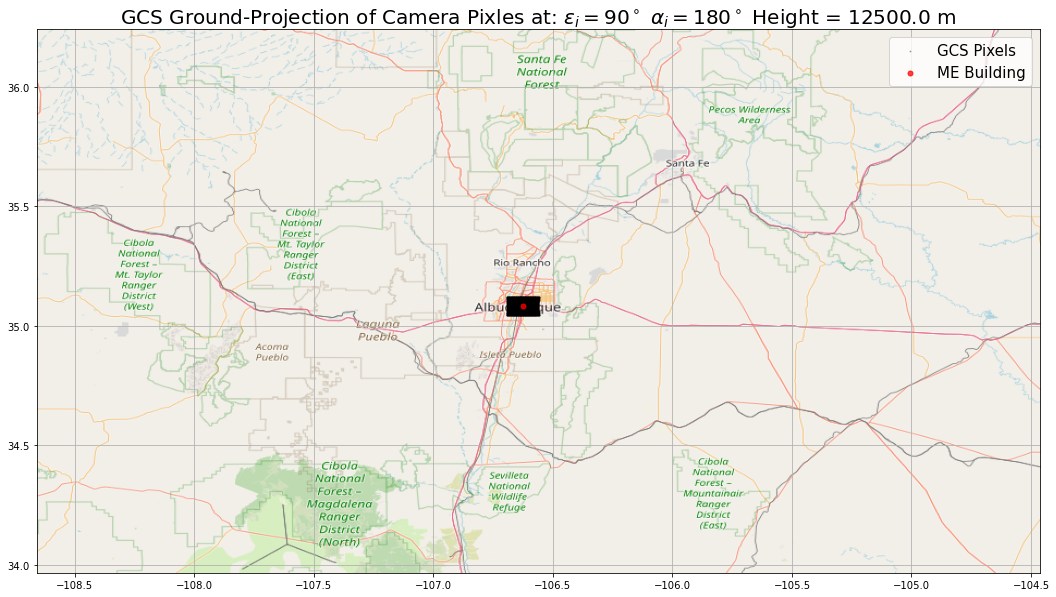

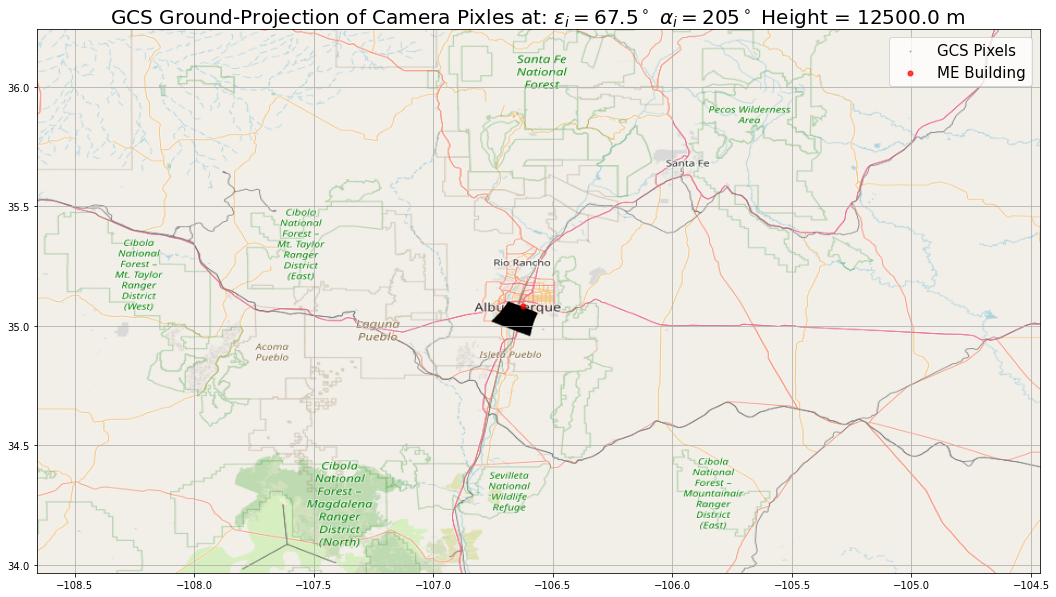

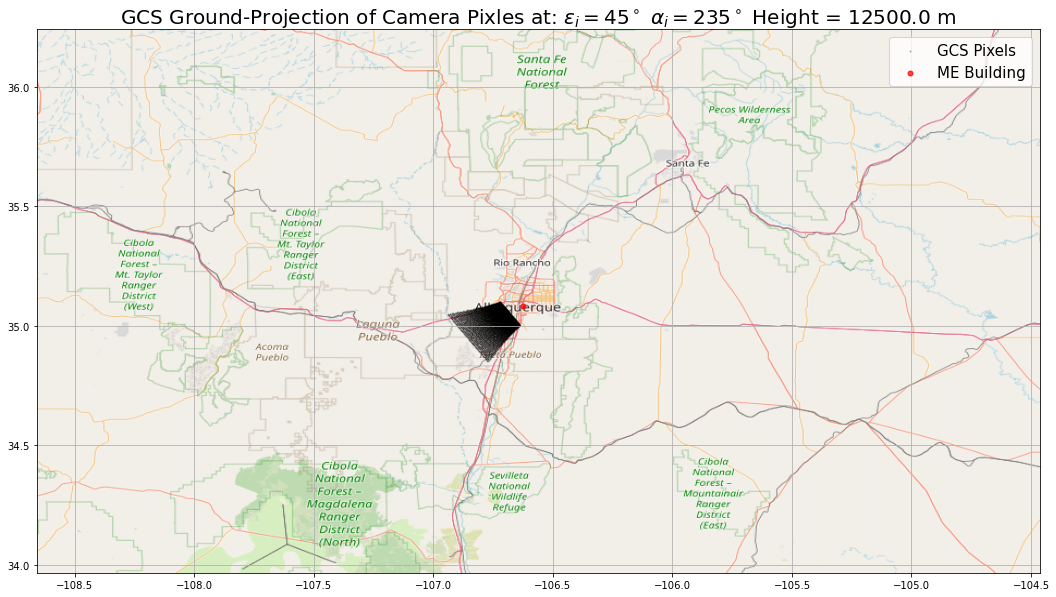

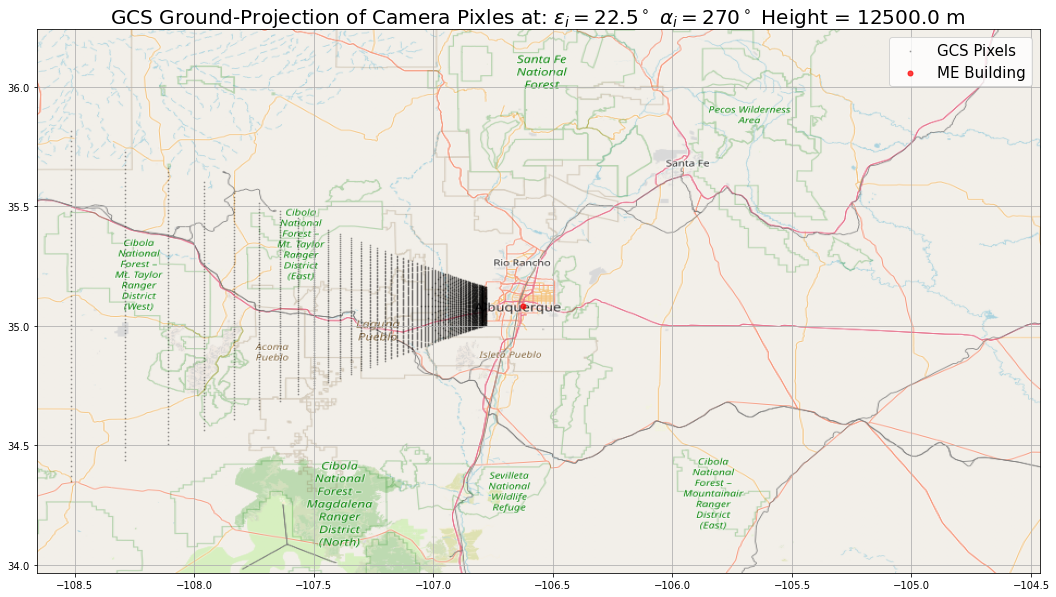

In [11]:
def _plot_map(XY_, M_, longitude, latitude, epsilon, azimuth, height, lim_):
    fig, ax = plt.subplots(figsize = (20, 10))
    ax.scatter(XY_[..., 0].flatten(), XY_[..., 1].flatten(), alpha = .25, s = 1., c = 'k', label = r'GCS Pixels')
    ax.scatter(longitude, latitude, zorder = 1, s = 25, alpha = .75, c = 'r', label = r'ME Building')
    ax.set_title(r'GCS Ground-Projection of Camera Pixles at: $\varepsilon_i = {}^\circ$ $\alpha_i = {}^\circ$ Height = {} m'.format(
                epsilon, azimuth, height), fontsize = 20)
    ax.set_xlim(lim_[0], lim_[1])
    ax.set_ylim(lim_[2], lim_[3])
    ax.imshow(M_, zorder = 0, extent = lim_, aspect= 'equal')
    ax.legend(fontsize = 15)
    ax.grid()
    plt.show()

# Load-up New Mexico Map
map_ = plt.imread(r'/Users/Guille/Desktop/prespective_transformation/data/map.png')

# ME Building Localization
latitude  = 35.082074
longitude = -106.625857
    
# Camera Parameters
epsilon = 22.5
azimuth = 100
height  = 12500.
x_sun_ = [30, 40]

for epsilon, azimuth in zip([22.5, 45, 67.5, 90, 67.5,45, 22.5], [90, 125, 155, 180, 205, 235, 270]):
    XYZ_, dXYZ_, XY_, XY_p_, XY_pp_, _ = _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_, 
                                                                     epsilon, azimuth, latitude, 
                                                                     longitude, height)
    _plot_map(XY_pp_, map_, longitude, latitude, epsilon, azimuth, height, 
              lim_ = (-108.660, -104.464, 33.966, 36.240))

# Extra

(61,)
(3, 61)


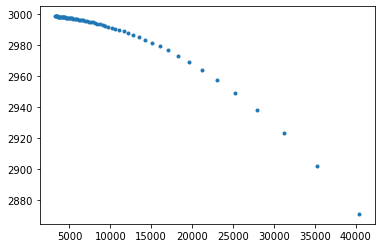

(60,)
[  73.92121061   75.7792932    77.72839818   79.77428598   81.92318719
   84.18184923   86.5575884    89.05834826   91.692765     94.470241
   97.40102765  100.49631873  103.76835616  107.23054965  110.89761274
  114.78571765  118.91267194  123.29812079  127.96377885  132.93369715
  138.23457084  143.89609538  149.95137985  156.43742823  163.39570167
  170.87277769  178.92112579  187.60002377  196.97664434  207.12734943
  218.13923859  230.11201004  243.16020871  257.41595565  273.0322802
  290.18721178  309.08883518  329.98157728  353.15407929  378.94912739
  407.77627876  440.12805009  476.60086134  517.92239449  564.98770583
  618.90743     681.07291018  753.24536381  837.67971522  937.29928331
 1055.94646571 1198.74931351 1372.66880829 1587.3348801  1856.35641812
 2199.43288321 2645.86669823 3240.61265607 4055.10233885 5207.41921381]
(60,)
[ 38.62231331  39.11046997  39.61624619  40.1404656   40.68400602
  41.24780398  41.83285965  42.44024224  43.07109603  43.72664698
  44.4

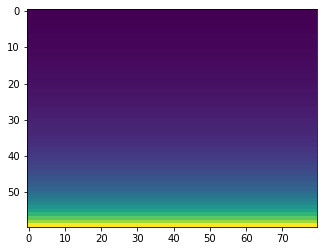

(60, 80) (60, 80)
35 35
2.2857142857142856 1.7777777777777777


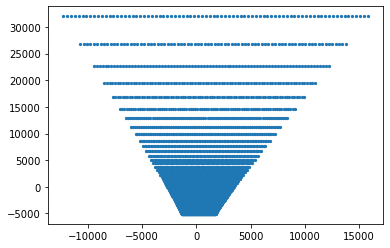

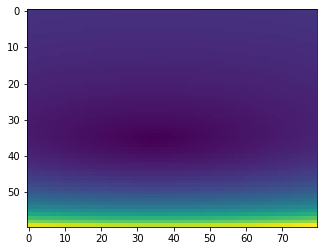

In [31]:
# New approch

def __quadratic_solution(W_, e_, height):
    N = e_.shape[0]
    x_ = np.zeros(N)
    y_ = np.zeros(N)
    z_ = np.zeros(N)
    for i in range(N):
        x_[i] = np.roots(W_[:, i])[1]
        y_[i] = x_[i] * np.tan(e_[i])
        z_[i] = y_[i] / np.sin(e_[i])
    return x_, y_, z_

def __quadratic_coefficient(e_, r, height):
    N = e_.shape[0]
    a_ = 1 + np.tan(e_)**2
    b_ = 2. * r * np.tan(e_)
    c  = - height * (1. + 2.*r)
    c_ = np.ones(N) * c
    return np.stack((a_, b_, c_))
    
def __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel):
    d_0 = x_sun_[0]
    d_1 = N_y - x_sun_[0]
    return np.linspace(epsilon + (d_0 + 1)*radians_per_pixel, epsilon - d_1*radians_per_pixel, N_y + 1)


def __x_axis(z_, FOV_y):
    alpha = FOV_y/2.
    x_ = 2*np.tan(alpha)*z_[1:]
    
    n_x = np.linspace(0, N_x//2 - 1, N_x//2)

    for i in range(x_.shape[0]):
        a = - 4.
        b = 8.*r
        c = - x_[i]**2 
        h = np.roots([a, b, c])[1]
        chi = h + x_[i]**2/(4.*h)
        x_[i] = np.arcsin(x_[i]/chi) * chi
    dx_ = x_/N_x
    return x_, dx_

def __y_axis(y_, x_):
    dx_ = np.diff(x_)
    dy_ = np.absolute(np.diff(y_))
    dz_ = dx_/np.cos(np.arctan(dy_/dx_))
    z_  = np.cumsum(dz_)
    return z_, dz_

def __grid(x_, dx_, N_x):
    X_  = np.tile(x_, (N_x, 1)).T
    dX_ = np.tile(dx_, (N_x, 1)).T
    return X_, dX_

def __center(X_, Y_, x_sun_, N_x):
    y_0, x_0 = x_sun_
    print(y_0, x_0)
    Y_0_ = Y_ - Y_[y_0, x_0]
    
    d_0 = N_x/x_0
    d_1 = N_x/(N_x - x_0)
    print(d_0, d_1)
    
    x_0_ = X_[:, x_0]
    X_0_ = np.zeros(X_.shape)
    
    for i in range(x_0_.shape[0]):
        X_0_[i, :] = np.linspace(-x_0_[i]/d_0, x_0_[i]/d_1, N_x)


    return X_0_, Y_0_, np.sqrt(X_0_**2 + Y_0_**2)


e_ = __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel)
print(e_.shape)

W_ = __quadratic_coefficient(e_, r, height)
print(W_.shape)
x_, y_, z_ = __quadratic_solution(W_, e_, height)

plt.figure()
plt.plot(x_, y_, '.')
plt.show()

y_, dy_ = __y_axis(y_, x_)
print(y_.shape)
print(dy_)

x_, dx_ = __x_axis(z_, FOV_y)
print(x_.shape)
print(dx_)

X_p_, dX_p_ = __grid(x_, dx_, N_x)
print(X_p_.shape, dX_p_.shape)

plt.figure()
plt.imshow(X_p_)
plt.show()

Y_p_, dY_p_ = __grid(y_, dy_, N_x)
print(Y_p_.shape, dY_p_.shape)



X_0_, Y_0_, Z_0_ = __center(X_p_, Y_p_, x_sun_, N_x)


plt.figure()
plt.scatter(X_0_.flatten(), Y_0_.flatten(), s = 5)
plt.show()

plt.figure()
plt.imshow(Z_0_)
plt.show()

428
(60, 80, 3) 20 13000.0


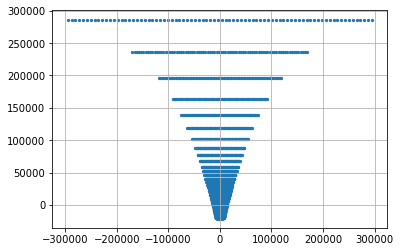

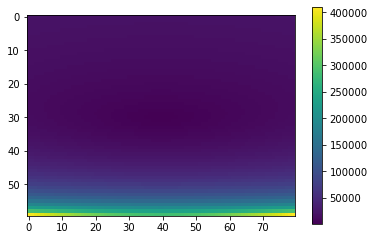

In [17]:
def _perspective_transformation_v3(X_, Y_, N_x, N_y, x_sun_, A_sun_, height, 
                                   altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
    # Solve Troposphere and Earth Surface Chords equation
    def __quadratic_solution(W_, e_, height):
        N = e_.shape[0]
        x_ = np.zeros(N)
        y_ = np.zeros(N)
        z_ = np.zeros(N)
        for i in range(N):
            x_[i] = np.roots(W_[:, i])[1]
            y_[i] = x_[i] * np.tan(e_[i])
            z_[i] = height / np.sin(e_[i])
        return x_, y_, z_

    # Compute coefficients of the Troposphere and Earth Surface Chords equation
    def __quadratic_coefficient(e_, r, height):
        N = e_.shape[0]
        a_ = 1 + np.tan(e_)**2
        b_ = 2. * r * np.tan(e_)
        c  = - height * (1. + 2.*r)
        c_ = np.ones(N) * c
        return np.stack((a_, b_, c_))

    # Extend Elevation from Sun's Elevation Angle for each pixel
    def __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel):
        d_0 = x_sun_[0]
        d_1 = N_y - x_sun_[0]
        return np.linspace(epsilon + (d_0 + 1)*radians_per_pixel, epsilon - d_1*radians_per_pixel, N_y + 1)

    # Project the Cross-Section plane in the Camera pLane
    def __cross_section_plane_coordinates(x_, y_, z_, FOV_y, N_x):
        # Calculate Increments per pixels in the x axis
        def __x_axis(z_, FOV_y):
            alpha = FOV_y/2.
            x_  = 2*np.tan(alpha)*z_[1:]
            dx_ = x_/N_x
            return x_, dx_
        # Calculate Increments per pixels in the y axis
        def __y_axis(y_, x_):
            dx_ = np.diff(x_)
            dy_ = np.absolute(np.diff(y_))
            dz_ = dx_/np.cos(np.arctan(dy_/dx_))
            z_  = np.cumsum(dz_)
            return z_, dz_
        # Reshape Vectors to Matrix form
        def __grid(x_, dx_, N_x):
            X_  = np.tile(x_, (N_x, 1)).T
            dX_ = np.tile(dx_, (N_x, 1)).T
            return X_, dX_

        # Calculate Increments per pixels in the x and y axis
        y_, dy_ = __y_axis(y_, x_)
        x_, dx_ = __x_axis(z_, FOV_y)

        # Reshape Vectors to Matrix form
        X_p_, dX_p_ = __grid(x_, dx_, N_x)
        Y_p_, dY_p_ = __grid(y_, dy_, N_x)
        dZ_p_ = np.sqrt(dX_p_**2 + dY_p_**2)
        return X_p_, Y_p_, dX_p_, dY_p_, dZ_p_
        
    # Set the origen of the Coordinates plane in the Sun Position in the frame
    def __set_origen_in_sun(X_, Y_, x_sun_, N_x):
        y_0, x_0 = x_sun_

        x_0_ = X_[:, x_0]
        X_0_ = np.zeros(X_.shape)

        d_0 = N_x/x_0
        d_1 = N_x/(N_x - x_0)
        
        for i in range(x_0_.shape[0]):
            X_0_[i, :] = np.linspace(-x_0_[i]/d_0, x_0_[i]/d_1, N_x)
            
        Y_0_ = Y_ - Y_[y_0, x_0]
        Z_0_ = np.sqrt(X_0_**2 + Y_0_**2)
        return X_0_, Y_0_, Z_0_
    
    # Perpendicular FOV as frame pixels limits
    def __prespective_limits(X_ppp_, Y_ppp_):
        #X_perp_, Y_perp_, _, _, _ = __get_distance(height = 13000, epsilon = 1.39626)
        X_perp_, Y_perp_, _, _, _ = __get_distance(height = 13000, epsilon = np.pi/2)

        X_perp_0_, Y_perp_0_, Z_perp_0_ = __set_origen_in_sun(X_perp_, Y_perp_, x_sun_, N_x)
        x_lim_ = X_perp_0_[:, -1]
        y_lim_ = Y_perp_0_[:, -1] 

        idx_x_ = X_ppp_ <= np.tile(x_lim_, (N_x, 1)).T + 1
        idx_y_ = ( Y_ppp_ < y_lim_.max() + 1) & ( Y_ppp_ > y_lim_.min() - 1 )

        return idx_x_ & idx_y_
    
    def __interpolation_grid(X_, Y_, X_ppp_, Y_ppp_, N_x, N_y):
        # Perpendicular FOV as frame pixels limits
        index_ = __prespective_limits(X_ppp_, Y_ppp_)
        xx_= []
        Y_ = (N_y - 1)*( Y_ppp_[index_] - np.min(Y_ppp_[index_]))/(np.max(Y_ppp_[index_]) - np.min(Y_ppp_[index_]))
        for y in np.unique(Y_ppp_[index_]):
            idx_ = (Y_ppp_ == y) & index_
            x_ = (N_x - 1)*( X_ppp_[idx_] - np.min(X_ppp_[idx_]))/(np.max(X_ppp_[idx_]) - np.min(X_ppp_[idx_]))
            xx_.append(x_)
        X_ = np.concatenate(xx_, axis = 0)
        return [np.concatenate((X_[:, np.newaxis],  Y_[:, np.newaxis]), axis = 1), index_]
    
    def __get_distance(epsilon, height):
        # Calculate Increments per pixels in the elevation
        e_ = __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel)
        # Calculate Coefficient on the chord second order equation
        W_ = __quadratic_coefficient(e_, r, height)
        # Solution of the Quadratic Equation
        x_, y_, z_ = __quadratic_solution(W_, e_, height)
        # Frame distance projected in the cross-section plane
        return __cross_section_plane_coordinates(x_, y_, z_, FOV_y, N_x)
    
    # Elevation Angle from Degrees to Radiantes
    #epsilon = A_sun_[0, 0]
    epsilon = np.radians(A_sun_)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    # Camera Constants
    const = pixel_size/focal_length
    alpha_y = radians_per_pixel*FOV_y/2
    # Sky-Parcel Geometric Constants
    r_earth  = 6371000.    # Average Earth radius
    r = r_earth + altitude # Earth radious in albuquerque

            
    X_p_, Y_p_, dX_p_, dY_p_, dZ_p_ = __get_distance(epsilon, height)
 
    # Set the origen of the Coordinates plane in the Sun Position in the frame
    X_0_, Y_0_, Z_0_ = __set_origen_in_sun(X_p_, Y_p_, x_sun_, N_x)

    # Stack together the Coordinates system and the incrementes in the coordinates grid
    XYZ_  = np.concatenate((X_0_[..., np.newaxis], Y_0_[..., np.newaxis], Z_0_[..., np.newaxis]), axis = 2)
    dXYZ_ = np.concatenate((dX_p_[..., np.newaxis], dY_p_[..., np.newaxis], dZ_p_[..., np.newaxis]), axis = 2)
    # Transformation of the camerea trjectory to pixels on the images
    #x_ = A_sun_.copy()
    x_ = A_sun_
    #x_[0, :] = (x_[0, :] - x_[0, 0]) / angles_per_pixel
    #x_[1, :] = (x_[1, :] - x_[1, 0]) / angles_per_pixel
    
    XY_interp_ = __interpolation_grid(X_, Y_, X_0_, Y_0_, N_x, N_y)
    print(np.sum(XY_interp_[1]))
#     plt.figure()
#     plt.scatter(XYZ_[..., 0].flatten(), XYZ_[..., 1].flatten(), s = 10)
#     plt.scatter(XYZ_[XY_interp_[1], 0].flatten(), XYZ_[XY_interp_[1], 1].flatten(), s = 10)
#     plt.show()
    
#     plt.figure()
#     plt.scatter(XY_interp_[0][:, 0], XY_interp_[0][:, 1], s = 10)
#     plt.show()

    return XYZ_, dXYZ_, x_
    
epsilon = 20
height  = 13000.
x_sun_ = [30, 40]

XYZ_, dXYZ_, x_ = _perspective_transformation_v3(X_, Y_, N_x, N_y, x_sun_, epsilon, height)
print(XYZ_.shape, epsilon, height)


plt.figure()
plt.scatter(XYZ_[..., 0].flatten(), XYZ_[..., 1].flatten(), s = 5)
plt.grid()
plt.show()

plt.figure()
plt.imshow(XYZ_[..., 2])
plt.colorbar()
plt.show()

-3036.340059210534 1718.8733853924696


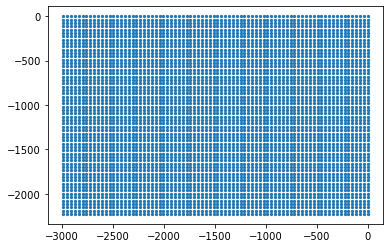

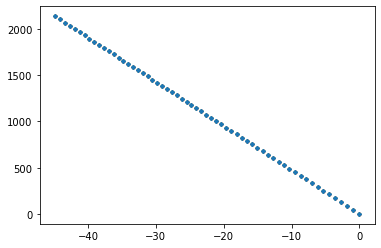

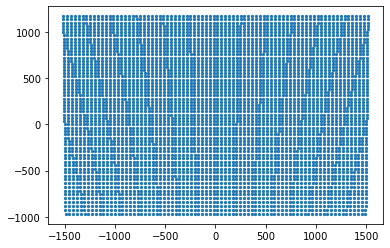

In [163]:
# Transform the Coordinates Plane to the Camera Plane
def __camera_plane_coordinates(X_, Y_, z, const):
    return X_ * dist * const, Y_ * dist * const
# Project the Cross-Section plane in the Camera pLane
def __cross_section_plane_coordinates(X_p_, Y_p_, X_pp_, Y_pp_, N_x):
    return X_p_ + np.cumsum(X_pp_/N_x, axis = 1), Y_pp_
# Calculate the Cross-Section Coodinates System
def __cross_seccion_coordinates(epsilon, dist, N_x, N_y, radians_per_pixel):
    # Transformation of the y-axis
    def ___y_axis(alpha_y_, height, epsilon):
        angle_upper_ = epsilon + alpha_y_
        angle_lower_ = epsilon - alpha_y_
        idx_ = angle_upper_ > np.pi/2
        y_ = height/np.tan(epsilon)
        y_upper = y_ - height/np.tan(angle_upper_)
        y_lower = height/np.tan(angle_lower_) - y_
        y_p_ = np.concatenate((-np.flip(y_upper), y_lower), axis = 0)
        y_p_+= np.absolute(y_p_[0])
        return y_p_
    # Transformation of the x-axis
    def ___x_axis(y_, alpha_y_, epsilon):
        return ( np.tan(alpha_y_[-1])*y_ )/( np.cos(alpha_y_[-1])*(np.tan(epsilon)*(1./np.tan(alpha_y_[-1])) + 1) )
    # Extend the FOV for each pixels along the y-axis
    alpha_y_ = np.linspace(radians_per_pixel/2, radians_per_pixel*N_y/2, N_y//2)
    # Get the Coordiantes transformation in the 4 Cuadrantes of the Coordinates system
    y_ = ___y_axis(alpha_y_, height, epsilon)
    x_ = ___x_axis(y_, alpha_y_, epsilon)
    # Repeat the vectors along the x-axis
    return np.tile(x_, (N_x, 1)).T, np.tile(y_, (N_x, 1)).T

dist = height/np.sin(epsilon)
print(dist, np.degrees(epsilon))
# Camera Plane Coordinates
X_p_, Y_p_ = __camera_plane_coordinates(X_, Y_, dist, const)

plt.figure()
plt.scatter(X_p_.flatten(), Y_p_.flatten(), s = 5)
plt.show()

# Cross-Section Plane Coordinates
X_pp_, Y_pp_ = __cross_seccion_coordinates(epsilon, dist, N_x, N_y, radians_per_pixel)

plt.figure()
plt.scatter(X_pp_.flatten(), Y_pp_.flatten(), s = 5)
plt.show()

# Cross-Section Coordinates Projected in the Plane
X_ppp_, Y_ppp_ = __cross_section_plane_coordinates(X_p_, Y_p_, X_pp_, Y_pp_, N_x)
# Set the origen of the Coordinates plane in the Suns
X_ppp_ -= np.tile(np.mean(X_ppp_, axis = 1), (N_x, 1)).T
Y_ppp_ -= Y_ppp_[int(np.around(x_sun_[1])), int(np.around(x_sun_[0]))]

plt.figure()
plt.scatter(X_ppp_.flatten(), Y_ppp_.flatten(), s = 5)
plt.show()

(61,)
(3, 61)
(61,) (61,) (61,)


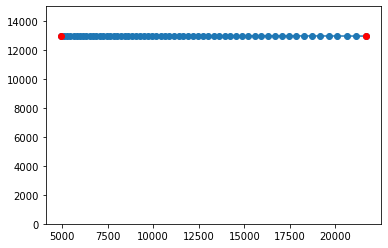

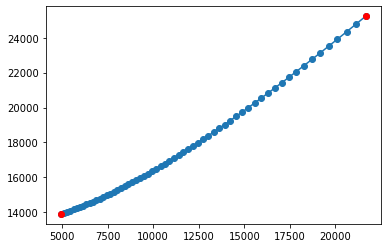

(80, 1) (60, 1)
(60, 80)
(60, 80) (60, 80)


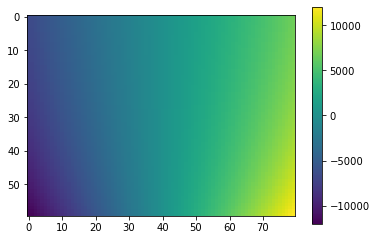

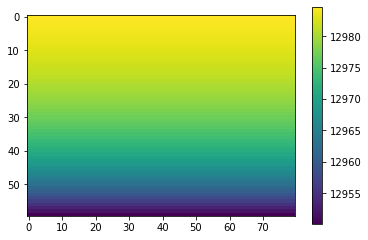

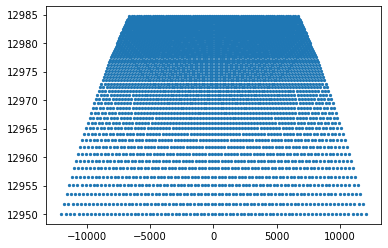

In [70]:
def __quadratic_solution(W_, e_, height):
    N = e_.shape[0]
    x_ = np.zeros(N)
    y_ = np.zeros(N)
    z_ = np.zeros(N)
    for i in range(N):
        x_[i] = np.roots(W_[:, i])[1]
        y_[i] = x_[i] * np.tan(e_[i])
        z_[i] = y_[i] / np.sin(e_[i])
    return x_, y_, z_

def __quadratic_coefficient(e_, r, height):
    N = e_.shape[0]
    a_ = 1 + np.tan(e_)**2
    b_ = 2. * r * np.tan(e_)
    c  = - height * (1. + 2.*r)
    c_ = np.ones(N) * c
    return np.stack((a_, b_, c_))
    
def __coordiantes_elevation(Y_, epsilon, FOV_y, radians_per_pixel):
    alpha = epsilon + FOV_y/2
    A_ = alpha - (Y_[:, 0] + 1)*radians_per_pixel
    return np.hstack((alpha, A_))


def __x_axis(z_, FOV_y):
    alpha_ = np.linspace(-FOV_x/2, FOV_x/2, N_x)[:, np.newaxis]
    z_p_ = z_[1:][:, np.newaxis]
    print(alpha_.shape, z_p_.shape)
    X_ = z_p_ @ np.tan(alpha_).T
    print(X_.shape)
    return X_

def __y_axis(y_, N_x):
    y_p_ = y_[1:]
    return np.tile(y_p_, (N_x, 1)).T
    
e_ = __coordiantes_elevation(Y_, epsilon, FOV_y, radians_per_pixel)
print(e_.shape)

W_ = __quadratic_coefficient(e_, r, height)
print(W_.shape)

x_, y_, z_ = __quadratic_solution(W_, e_, height)
print(x_.shape, y_.shape, z_.shape)

plt.figure()
plt.plot(x_, y_, '-o')
plt.plot(x_[0], y_[0], 'ro')
plt.plot(x_[-1], y_[-1], 'ro')
plt.ylim(0, 15000)
plt.show()

plt.figure()
plt.plot(x_, z_, '-o')
plt.plot(x_[0], z_[0], 'ro')
plt.plot(x_[-1], z_[-1], 'ro')
#plt.ylim(0, 15000)
plt.show()

X_p_ = __x_axis(z_, FOV_y)
Y_p_ = __y_axis(y_, N_x)
print(X_p_.shape, Y_p_.shape)

plt.figure()
plt.imshow(X_p_)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(Y_p_)
plt.colorbar()
plt.show()

plt.figure()
plt.scatter(X_p_.flatten(), Y_p_.flatten(), s = 5)
plt.show()

(60, 80) (60, 80) (60, 80)
(60, 80) (60, 80)


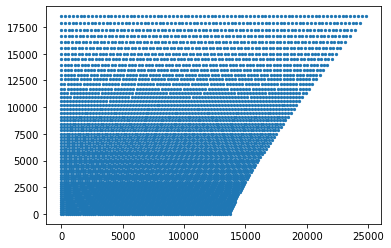

(60, 80) (60, 80)
(60, 80) (60, 80)


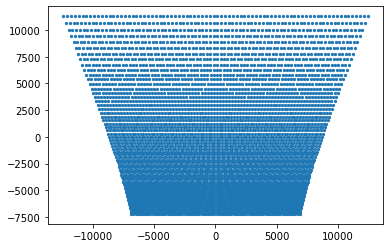

In [71]:
# Transform the Coordinates Plane to the Camera Plane
def __camera_plane_coordinates(X_, Y_, dist, const):
    return X_ * const * dist, Y_ * const * dist

# Project the Cross-Section plane in the Camera pLane
def __cross_section_plane_coordinates(X_p_, Y_p_, dz_, alpha_y, N_x):
    dx_ = np.arctan(alpha_y) * dz_
    dX_ = np.tile(dz_, (N_x, 1)).T
    return X_p_ + dX_,  Y_p_

def __set_origen(X_ppp_, Y_ppp_):
    dX_0_ = np.tile(np.mean(X_ppp_, axis = 1), (N_x, 1)).T
    dY_0_ = np.tile(np.mean(Y_ppp_, axis = 0), (N_y, 1))
    return X_ppp_ - dX_0_, Y_ppp_ - dY_0_

def __dxyz(x_, y_, z_):
    dx_ = np.diff(x_)
    dy_ = np.diff(y_)
    dz_ = np.diff(z_)
    x_ = x_[1:]
    y_ = y_[1:]
    z_ = z_[1:]
    return x_, y_, z_, dx_, dy_, dz_


def __reshape(x_, y_, z_, N_x):
    X_ = np.tile(x_, (N_x, 1)).T
    Y_ = np.tile(y_, (N_x, 1)).T
    Z_ = np.tile(z_, (N_x, 1)).T
    return X_, Y_, Z_

x_, y_, z_, dx_, dy_, dz_ = __dxyz(x_, y_, z_)


X_p_, Y_p_, Z_p_ = __reshape(x_, y_, z_, N_x)
print(X_p_.shape, Y_p_.shape, Z_p_.shape)

X_pp_, Y_pp_ = __camera_plane_coordinates(X_, Y_, Z_p_, const)
print(X_pp_.shape, Y_pp_.shape)

plt.figure()
plt.scatter(X_pp_.flatten(), Y_pp_.flatten(), s = 5)
plt.show()

alpha_y = radians_per_pixel*FOV_y/2
X_ppp_, Y_ppp_ = __cross_section_plane_coordinates(X_pp_, Y_pp_, dz_, alpha_y, N_x)
print(X_ppp_.shape, Y_ppp_.shape)

# Set the origen of the Coordinates plane in the middle of the frame
X_ppp_, Y_ppp_ = __set_origen(X_ppp_, Y_ppp_)
print(X_ppp_.shape, Y_ppp_.shape)

plt.figure()
plt.scatter(X_ppp_.flatten(), Y_ppp_.flatten(), s = 5)
plt.show()

356
(60, 80, 3) 20 13000.0


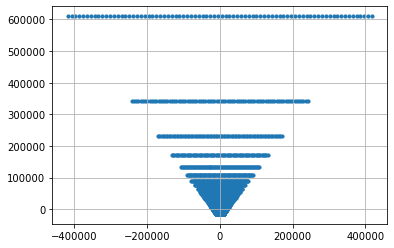

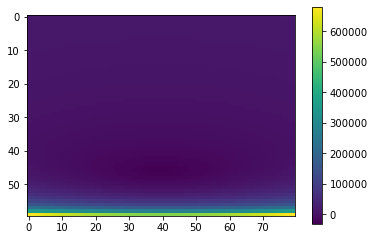

In [19]:
def _perspective_transformation_v2(X_, Y_, N_x, N_y, x_sun_, A_sun_, height, 
                                   altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
    # Solve Troposphere and Earth Surface Chords equation
    def __quadratic_solution(W_, e_, height):
        N = e_.shape[0]
        x_ = np.zeros(N)
        y_ = np.zeros(N)
        z_ = np.zeros(N)
        for i in range(N):
            x_[i] = np.roots(W_[:, i])[1]
            y_[i] = x_[i] * np.tan(e_[i])
            z_[i] = height / np.sin(e_[i])
        return x_, y_, z_

    # Compute coefficients of the Troposphere and Earth Surface Chords equation
    def __quadratic_coefficient(e_, r, height):
        N = e_.shape[0]
        a_ = 1 + np.tan(e_)**2
        b_ = 2. * r * np.tan(e_)
        c  = - height * (1. + 2.*r)
        c_ = np.ones(N) * c
        return np.stack((a_, b_, c_))

    # Extend Elevation from Sun's Elevation Angle for each pixel
    def __coordiantes_elevation(Y_, epsilon, FOV_y, radians_per_pixel):
        alpha = epsilon + FOV_y/2
        A_ = alpha - (Y_[:, 0] + 1)*radians_per_pixel
        return np.hstack((alpha, A_))

    # Transform the Coordinates Plane to the Camera Plane
    def __camera_plane_coordinates(X_, Y_, dist, const):
        return X_ * const * dist, Y_ * const * dist

    # Project the Cross-Section plane in the Camera pLane
    def __cross_section_plane_coordinates(X_p_, Y_p_, dz_, alpha_y, N_x):
        dx_ = np.arctan(alpha_y) * dz_
        dX_ = np.tile(dz_, (N_x, 1)).T
        return X_p_ + dX_, Y_p_
    
    # Set the origen of the Coordinates plane in the middle of the frame
    def __set_origen(X_ppp_, Y_ppp_):
        X_ppp_0_ = X_ppp_ - np.tile(np.mean(X_ppp_, axis = 1), (N_x, 1)).T
        Y_ppp_0_ = Y_ppp_ - np.tile(np.mean(Y_ppp_, axis = 0), (N_y, 1))
        # Calulate the Distance from any pixel to the sun
        Z_ppp_0_ = np.sqrt(X_ppp_0_**2 + Y_ppp_0_**2)
        return X_ppp_0_, Y_ppp_0_, Z_ppp_0_
    
    # Vector Increments in each coordiante direction
    def __dxyz(x_, y_, z_):
        dx_ = np.diff(x_)
        dy_ = np.diff(y_)
        dz_ = np.diff(z_)
        x_ = x_[1:]
        y_ = y_[1:]
        z_ = z_[1:]
        return x_, y_, z_, dx_, dy_, dz_
    
    # Calculate Increments per pixels in the x, y, and z axis
    def __get_increments(X_ppp_, Y_ppp_):
        dX_ppp_ = np.gradient(X_ppp_, axis = 1)
        dY_ppp_ = np.gradient(Y_ppp_, axis = 0)
        dZ_ppp_ = np.sqrt(dY_ppp_**2 + dY_ppp_**2)
        return dX_ppp_, dY_ppp_, dZ_ppp_
    
    # Reshape Vectors to Matrix form
    def __reshape(x_, y_, z_, N_x):
        X_ = np.tile(x_, (N_x, 1)).T
        Y_ = np.tile(y_, (N_x, 1)).T
        Z_ = np.tile(z_, (N_x, 1)).T
        return X_, Y_, Z_
    
    # Frame distance projected in the camera plane
    def __get_distances(Y_, height = 13000, epsilon = np.pi/2):
        # Extend Elevation from Sun's Elevation Angle for each pixel
        e_ = __coordiantes_elevation(Y_, epsilon, FOV_y, radians_per_pixel)
        # Compute coefficients of the Troposphere and Earth Surface Chords equation
        W_ = __quadratic_coefficient(e_, r, height)
        # Solve Troposphere and Earth Surface Chords equation
        x_, y_, z_ = __quadratic_solution(W_, e_, height)
        # Vector Increments in each coordiante direction
        x_, y_, z_, dx_, dy_, dz_ = __dxyz(x_, y_, z_)
        # Reshape Vectors to Matrix form
        X_p_, Y_p_, Z_p_ = __reshape(x_, y_, z_, N_x)
        # Calculate Coordiantes projected in the Camera Plane
        X_pp_, Y_pp_ = __camera_plane_coordinates(X_, Y_, Z_p_, const)
        # Calculate Coordiantes projected in the Cross-Section Plane of the Troposphere
        return __cross_section_plane_coordinates(X_pp_, Y_pp_, dz_, alpha_y, N_x)
        
    # Set the origen of the Coordinates plane in the Sun Position in the frame
    def __set_origen_in_sun(X_ppp_, Y_ppp_, Z_ppp_, x_sun_):
        X_ppp_ -= X_ppp_[int(np.around(x_sun_[0])), int(np.around(x_sun_[1]))]
        Y_ppp_ -= Y_ppp_[int(np.around(x_sun_[0])), int(np.around(x_sun_[1]))]
        Z_ppp_ -= Z_ppp_[int(np.around(x_sun_[0])), int(np.around(x_sun_[1]))]
        return X_ppp_, Y_ppp_, Z_ppp_
    
    # Perpendicular FOV as frame pixels limits
    def __prespective_limits(Y_, X_ppp_, Y_ppp_):
        X_perp_, Y_perp_ = __get_distances(Y_, height = 13000, epsilon = 1.39626)
        #X_perp_, Y_perp_ = __get_distances(Y_, height = 13000, epsilon = np.pi/2)
        X_perp_0_, Y_perp_0_, _ = __set_origen(X_perp_, Y_perp_)
        x_lim_ = X_perp_0_[:, -1] + 1
        y_lim_ = Y_perp_0_[:, -1]
        idx_x_ = np.absolute(X_ppp_) <= np.tile(x_lim_, (N_x, 1)).T
        idx_y_ = np.absolute(Y_ppp_) <= y_lim_[-1]
        return idx_x_ & idx_y_
    
    def __interpolation_grid(X_, Y_, X_ppp_, Y_ppp_, N_x, N_y):
        # Perpendicular FOV as frame pixels limits
        index_ = __prespective_limits(Y_, X_ppp_, Y_ppp_)
        xx_= []
        Y_ = (N_y - 1)*( Y_ppp_[index_] - np.min(Y_ppp_[index_]))/(np.max(Y_ppp_[index_]) - np.min(Y_ppp_[index_]))
        for y in np.unique(Y_ppp_[index_]):
            idx_ = (Y_ppp_ == y) & index_
            x_ = (N_x - 1)*( X_ppp_[idx_] - np.min(X_ppp_[idx_]))/(np.max(X_ppp_[idx_]) - np.min(X_ppp_[idx_]))
            xx_.append(x_)
        X_ = np.concatenate(xx_, axis = 0)
        return [np.concatenate((X_[:, np.newaxis],  Y_[:, np.newaxis]), axis = 1), index_]
    
    # Elevation Angle from Degrees to Radiantes
    #epsilon = A_sun_[0, 0]
    epsilon = np.radians(A_sun_)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    # Camera Constants
    const = pixel_size/focal_length
    alpha_y = radians_per_pixel*FOV_y/2
    # Sky-Parcel Geometric Constants
    r_earth  = 6371000.    # Average Earth radius
    r = r_earth + altitude # Earth radious in albuquerque
    dist = height/np.sin(epsilon)

    # Frame distance projected in the camera plane and the cross-section plane
    X_ppp_, Y_ppp_ = __get_distances(Y_, height, epsilon)
    # Calculate Increments per pixels in the x, y, and z axis
    dX_ppp_, dY_ppp_, dZ_ppp_ = __get_increments(X_ppp_, Y_ppp_)
    # Set the origen of the Coordinates plane in the middle of the frame
    X_ppp_, Y_ppp_, Z_ppp_= __set_origen(X_ppp_, Y_ppp_)
    # Set the origen of the Coordinates plane in the Sun Position in the frame
    X_ppp_, Y_ppp_, Z_ppp_ = __set_origen_in_sun(X_ppp_, Y_ppp_, Z_ppp_, x_sun_)

    # Stack together the Coordinates system and the incrementes in the coordinates grid
    XYZ_  = np.concatenate(( X_ppp_[..., np.newaxis],  Y_ppp_[..., np.newaxis],  Z_ppp_[..., np.newaxis]), axis = 2)
    dXYZ_ = np.concatenate((dX_ppp_[..., np.newaxis], dY_ppp_[..., np.newaxis], dZ_ppp_[..., np.newaxis]), axis = 2)
    # Transformation of the camerea trjectory to pixels on the images
    #x_ = A_sun_.copy()
    x_ = A_sun_
    #x_[0, :] = (x_[0, :] - x_[0, 0]) / angles_per_pixel
    #x_[1, :] = (x_[1, :] - x_[1, 0]) / angles_per_pixel
    
    XY_interp_ = __interpolation_grid(X_, Y_, X_ppp_, Y_ppp_, N_x, N_y)
    print(np.sum(XY_interp_[1]))


    return XYZ_, dXYZ_, x_
    
epsilon = 20
height  = 13000.
XYZ_, dXYZ_, x_ = _perspective_transformation_v2(X_, Y_, N_x, N_y, x_sun_, epsilon, height)
print(XYZ_.shape, epsilon, height)


plt.figure()
plt.scatter(XYZ_[..., 0].flatten(), XYZ_[..., 1].flatten(), s = 10)
plt.grid()
plt.show()
    
plt.figure()
plt.imshow(XYZ_[..., 2])
plt.colorbar()
plt.show()

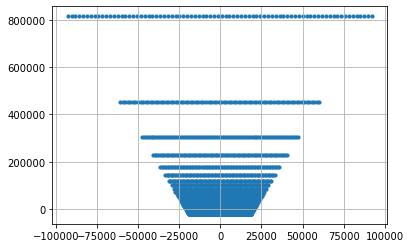

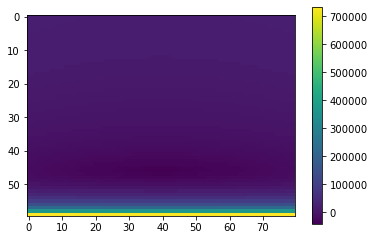

In [20]:
def _perspective_transformation_v1(X_, Y_, N_x, N_y, x_sun_, A_sun_, height, altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
    
    # Transform the Coordinates Plane to the Camera Plane
    def __camera_plane_coordinates(X_, Y_, dist, const):
        return X_ * dist * const, Y_ * dist * const
    
    # Project the Cross-Section plane in the Camera pLane
    def __cross_section_plane_coordinates(X_p_, Y_p_, X_pp_, Y_pp_, N_x):
        return X_p_ + np.cumsum(X_pp_/N_x, axis = 1), Y_pp_
    
    # Calculate the Cross-Section Coodinates System
    def __cross_seccion_coordinates(epsilon, dist, N_x, N_y, radians_per_pixel):
        # Transformation of the y-axis
        def ___y_axis(alpha_y_, height, epsilon):
            angle_upper_ = epsilon + alpha_y_
            angle_lower_ = epsilon - alpha_y_
            idx_ = angle_upper_ > np.pi/2
            y_ = height/np.tan(epsilon)
            y_upper = y_ - height/np.tan(angle_upper_)
            y_lower = height/np.tan(angle_lower_) - y_
            y_p_ = np.concatenate((-np.flip(y_upper), y_lower), axis = 0)
            y_p_+= np.absolute(y_p_[0])
            return y_p_
        # Transformation of the x-axis
        def ___x_axis(y_, alpha_y_, epsilon):
            return ( np.tan(alpha_y_[-1])*y_ )/( np.cos(alpha_y_[-1])*(np.tan(epsilon)*(1./np.tan(alpha_y_[-1])) + 1) )
        # Extend the FOV for each pixels along the y-axis
        alpha_y_ = np.linspace(radians_per_pixel/2, radians_per_pixel*N_y/2, N_y//2)
        # Get the Coordiantes transformation in the 4 Cuadrantes of the Coordinates system
        y_ = ___y_axis(alpha_y_, height, epsilon)
        x_ = ___x_axis(y_, alpha_y_, epsilon)
        # Repeat the vectors along the x-axis
        return np.tile(x_, (N_x, 1)).T, np.tile(y_, (N_x, 1)).T
    
    # Frame distance projected in the camera plane
    def __get_distances(X_, Y_, height = 13000, epsilon = np.pi/2):
        dist = height/np.sin(epsilon)
        # Camera Plane Coordinates
        X_p_, Y_p_ = __camera_plane_coordinates(X_, Y_, dist, const)
        # Cross-Section Plane Coordinates
        X_pp_, Y_pp_ = __cross_seccion_coordinates(epsilon, dist, N_x, N_y, radians_per_pixel)
        return X_p_, Y_p_, X_pp_, Y_pp_
    
    # Perpendicular FOV as frame pixels limits
    def __prespective_limits(X_, Y_, X_ppp_, Y_ppp_):
        X_perp_, _, _, Y_perp_ = __get_distances(X_, Y_)
        X_perp_0_, Y_perp_0_, _ = __set_origen(X_perp_, Y_perp_)
        x_lim = X_perp_0_[-1, -1] + 1
        y_lim = Y_perp_0_[-1, -1] + 1
        idx_x_ = np.absolute(X_ppp_) <= x_lim
        idx_y_ = np.absolute(Y_ppp_) <= y_lim
        return idx_x_ & idx_y_
    
    # Calculate Increments per pixels in the x, y, and z axis
    def __get_increments(X_ppp_, Y_ppp_):
        dX_ppp_ = np.gradient(X_ppp_, axis = 1)
        dY_ppp_ = np.gradient(Y_ppp_, axis = 0)
        dZ_ppp_ = np.sqrt(dY_ppp_**2 + dY_ppp_**2)
        return dX_ppp_, dY_ppp_, dZ_ppp_
    
    # Set the origen of the Coordinates plane in the middle of the frame
    def __set_origen(X_ppp_, Y_ppp_):
        X_ppp_0_ = X_ppp_ - np.tile(np.mean(X_ppp_, axis = 1), (N_x, 1)).T
        Y_ppp_0_ = Y_ppp_ - np.tile(np.mean(Y_ppp_, axis = 0), (N_y, 1))
        # Calulate the Distance from any pixel to the sun
        Z_ppp_0_ = np.sqrt(X_ppp_0_**2 + Y_ppp_0_**2)
        return X_ppp_0_, Y_ppp_0_, Z_ppp_0_
    
    # Set the origen of the Coordinates plane in the Sun Position in the frame
    def __set_origen_in_sun(X_ppp_, Y_ppp_, Z_ppp_, x_sun_):
        X_ppp_ -= X_ppp_[int(np.around(x_sun_[0])), int(np.around(x_sun_[1]))]
        Y_ppp_ -= Y_ppp_[int(np.around(x_sun_[0])), int(np.around(x_sun_[1]))]
        Z_ppp_ -= Z_ppp_[int(np.around(x_sun_[0])), int(np.around(x_sun_[1]))]
        return X_ppp_, Y_ppp_, Z_ppp_
    
    def __interpolation_grid(X_, Y_, X_ppp_, Y_ppp_, N_x, N_y):
        # Perpendicular FOV as frame pixels limits
        index_ = __prespective_limits(X_, Y_, X_ppp_, Y_ppp_)
        xx_= []
        Y_ = (N_y - 1)*( Y_ppp_[index_] - np.min(Y_ppp_[index_]))/(np.max(Y_ppp_[index_]) - np.min(Y_ppp_[index_]))
        for y in np.unique(Y_ppp_[index_]):
            idx_ = (Y_ppp_ == y) & index_
            x_ = (N_x - 1)*( X_ppp_[idx_] - np.min(X_ppp_[idx_]))/(np.max(X_ppp_[idx_]) - np.min(X_ppp_[idx_]))
            xx_.append(x_)
        X_ = np.concatenate(xx_, axis = 0)
        return [np.concatenate((X_[:, np.newaxis],  Y_[:, np.newaxis]), axis = 1), index_]
    
    # Elevation Angle from Degrees to Radiantes
    #epsilon = A_sun_[0, 0]
    epsilon = np.radians(A_sun_)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    #print(epsilon, angles_per_pixel, radians_per_pixel, FOV_x, FOV_y)
    # Camera Constants
    const = pixel_size/focal_length
    # Sky-Parcel Geometric Constants
    height = height 
    # Frame distance projected in the camera plane and the Cross-section plane y-axis
    X_p_, Y_p_, X_pp_, Y_pp_ = __get_distances(X_, Y_, height, epsilon)
    # Cross-Section Coordinates Projection in the x-axis
    X_ppp_, Y_ppp_ = __cross_section_plane_coordinates(X_p_, Y_p_, X_pp_, Y_pp_, N_x)
    # Calculate Increments per pixels in the x, y, and z axis
    dX_ppp_, dY_ppp_, dZ_ppp_ = __get_increments(X_ppp_, Y_ppp_)
    # Set the origen of the Coordinates plane in the Suns
    X_ppp_, Y_ppp_, Z_ppp_ = __set_origen(X_ppp_, Y_ppp_)
    # Set the origen of the Coordinates plane in the Sun Position in the frame
    X_ppp_, Y_ppp_, Z_ppp_ = __set_origen_in_sun(X_ppp_, Y_ppp_, Z_ppp_, x_sun_)
    # Stack together the Coordinates system and the incrementes in the coordinates grid
    XYZ_  = np.concatenate(( X_ppp_[..., np.newaxis],  Y_ppp_[..., np.newaxis],  Z_ppp_[..., np.newaxis]), axis = 2)
    dXYZ_ = np.concatenate((dX_ppp_[..., np.newaxis], dY_ppp_[..., np.newaxis], dZ_ppp_[..., np.newaxis]), axis = 2)
    # Transformation of the camerea trjectory to pixels on the images
    #x_ = A_sun_.copy()
    x_ = A_sun_
    #x_[0, :] = (x_[0, :] - x_[0, 0]) / angles_per_pixel
    #x_[1, :] = (x_[1, :] - x_[1, 0]) / angles_per_pixel

    
    XY_interp_ = __interpolation_grid(X_, Y_, X_ppp_, Y_ppp_, N_x, N_y)
    
#     plt.figure()
#     plt.scatter(XYZ_[..., 0].flatten(), XYZ_[..., 1].flatten(), s = 10)
#     plt.scatter(XYZ_[XY_interp_[1], 0].flatten(), XYZ_[XY_interp_[1], 1].flatten(), s = 10)
#     plt.show()
    
#     plt.figure()
#     plt.scatter(XY_interp_[0][:, 0], XY_interp_[0][:, 1], s = 10)
#     plt.show()

    return XYZ_, dXYZ_, x_
    
epsilon = 20
height  = 13000.
XYZ_, dXYZ_, x_ = _perspective_transformation_v1(X_, Y_, N_x, N_y, x_sun_, epsilon, height)

plt.figure()
plt.scatter(XYZ_[..., 0].flatten(), XYZ_[..., 1].flatten(), s = 10)
plt.grid()
plt.show()
    
plt.figure()
plt.imshow(XYZ_[..., 2])
plt.colorbar()
plt.show()

In [ ]:
def _perspective_transformation_v0(X_, Y_, N_x, N_y, x_sun_, A_sun_, height, 
                                   altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
    # Transform the Coordinates Plane to the Camera Plane
    def __camera_plane_coordinates(X_, Y_, dist, const):
        return X_ * dist * const, Y_ * dist * const
    # Project the Cross-Section plane in the Camera pLane
    def __cross_section_plane_coordinates(X_p_, Y_p_, X_pp_, Y_pp_, N_x):
        return X_p_ + np.cumsum(X_pp_/N_x, axis = 1), Y_pp_
    # Calculate the Cross-Section Coodinates System
    def __cross_seccion_coordinates(epsilon, dist, N_x, N_y, radians_per_pixel):
        # Transformation of the y-axis
        def ___y_axis(alpha_y_, height, epsilon):
            angle_upper_ = epsilon + alpha_y_
            angle_lower_ = epsilon - alpha_y_
            idx_ = angle_upper_ > np.pi/2
            y_ = height/np.tan(epsilon)
            y_upper = y_ - height/np.tan(angle_upper_)
            y_lower = height/np.tan(angle_lower_) - y_
            y_p_ = np.concatenate((-np.flip(y_upper), y_lower), axis = 0)
            y_p_+= np.absolute(y_p_[0])
            return y_p_
        # Transformation of the x-axis
        def ___x_axis(y_, alpha_y_, epsilon):
            return ( np.tan(alpha_y_[-1])*y_ )/( np.cos(alpha_y_[-1])*(np.tan(epsilon)*(1./np.tan(alpha_y_[-1])) + 1) )
        # Extend the FOV for each pixels along the y-axis
        alpha_y_ = np.linspace(radians_per_pixel/2, radians_per_pixel*N_y/2, N_y//2)
        # Get the Coordiantes transformation in the 4 Cuadrantes of the Coordinates system
        y_ = ___y_axis(alpha_y_, height, epsilon)
        x_ = ___x_axis(y_, alpha_y_, epsilon)
        # Repeat the vectors along the x-axis
        return np.tile(x_, (N_x, 1)).T, np.tile(y_, (N_x, 1)).T

    def __prespective_limits(X_ppp_, Y_ppp_, FOV_x, FOV_y, height, epsilon_max):
        dist_x = height*np.tan( FOV_x/2 )
        dist_y = height*np.tan( FOV_y/2 )
        print(dist_x, dist_y)
        print(X_ppp_.max(), X_ppp_.min())
        print(Y_ppp_.max(), Y_ppp_.min())

        idx_x_ = np.absolute(X_ppp_) <= dist_x + 200
        idx_y_ = np.absolute(Y_ppp_) <= dist_y + 75
        return idx_x_ & idx_y_

    def __interpolation_grid(X_ppp_, Y_ppp_, index_, N_x, N_y):
        xx_= []
        Y_ = (N_y - 1)*( Y_ppp_[index_] - np.min(Y_ppp_[index_]))/(np.max(Y_ppp_[index_]) - np.min(Y_ppp_[index_]))
        for y in np.unique(Y_ppp_[index_]):
            idx_ = (Y_ppp_ == y) & index_
            x_ = (N_x - 1)*( X_ppp_[idx_] - np.min(X_ppp_[idx_]))/(np.max(X_ppp_[idx_]) - np.min(X_ppp_[idx_]))
            xx_.append(x_)
        X_ = np.concatenate(xx_, axis = 0)
        return [np.concatenate((X_[:, np.newaxis],  Y_[:, np.newaxis]), axis = 1), index_]

    #epsilon = A_sun_[0, 0]
    epsilon = np.radians(A_sun_)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    #print(epsilon, angles_per_pixel, radians_per_pixel, FOV_x, FOV_y)
    # Camera Constants
    const = pixel_size/focal_length
    # Sky-Parcel Geometric Constants
    height   = height #- altitude
    #epsilon  = np.radians(epsilon)
    dist     = height/np.sin(epsilon)
    # Camera Plane Coordinates
    X_p_, Y_p_ = __camera_plane_coordinates(X_, Y_, dist, const)
    # Cross-Section Plane Coordinates
    X_pp_, Y_pp_ = __cross_seccion_coordinates(epsilon, dist, N_x, N_y, radians_per_pixel)
    # Cross-Section Coordinates Projected in the Plane
    X_ppp_, Y_ppp_ = __cross_section_plane_coordinates(X_p_, Y_p_, X_pp_, Y_pp_, N_x)
    # Calculate Increments per pixels in the x, y, and z axis
    dX_ppp_ = np.gradient(X_ppp_, axis = 1)
    dY_ppp_ = np.gradient(Y_ppp_, axis = 0)
    dZ_ppp_ = np.sqrt(dY_ppp_**2 + dY_ppp_**2)
    # Set the origen of the Coordinates plane in the Suns
    X_p_ -= X_p_[int(np.around(x_sun_[1])), int(np.around(x_sun_[0]))]
    Y_p_ -= Y_p_[int(np.around(x_sun_[1])), int(np.around(x_sun_[0]))]
    X_ppp_ -= np.tile(np.mean(X_ppp_, axis = 1), (N_x, 1)).T
    Y_ppp_ -= Y_ppp_[int(np.around(x_sun_[1])), int(np.around(x_sun_[0]))]
    # Calulate the Distance from any pixel to the sun
    Z_ppp_ = np.sqrt(X_ppp_**2 + Y_ppp_**2)
    # Stack together the Coordinates system and the incrementes in the coordinates grid
    XYZ_  = np.concatenate((X_ppp_[..., np.newaxis], Y_ppp_[..., np.newaxis], Z_ppp_[..., np.newaxis]), axis = 2)
    dXYZ_ = np.concatenate((dX_ppp_[..., np.newaxis], dY_ppp_[..., np.newaxis], dZ_ppp_[..., np.newaxis]), axis = 2)
    # Transformation of the camerea trjectory to pixels on the images
    #x_ = A_sun_.copy()
    x_ = A_sun_
    #x_[0, :] = (x_[0, :] - x_[0, 0]) / angles_per_pixel
    #x_[1, :] = (x_[1, :] - x_[1, 0]) / angles_per_pixel
    # Interpolation Pixels Indexes
    index_ = __prespective_limits(X_ppp_, Y_ppp_, FOV_x, FOV_y, height, epsilon_max = 90)
    print(np.sum(index_))
    # Interpolation Grid for equidistant pixels
    XY_interp_ = __interpolation_grid(X_ppp_, Y_ppp_, index_, N_x, N_y)
    print(len(XY_interp_), XY_interp_[0].shape, XY_interp_[1].shape)
    return XYZ_, dXYZ_, x_, XY_interp_

# Flat-Earth Approximation

In [43]:
def _perspective_transformation_v0(X_, Y_, N_x, N_y, x_sun_, A_sun_, height, 
                                   altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
    # Transform the Coordinates Plane to the Camera Plane
    def __camera_plane_coordinates(X_, Y_, pixel_size, focal_length):
        c = pixel_size/focal_length
        return X_ * c, Y_ * c
    # Project the Cross-Section plane in the Camera pLane
    def __cross_section_plane_coordinates(X_, Y_, X_p_, Y_p_, x_sun_, epsilon, height, N_x, N_y, 
                                          radians_per_pixel):
        y_0      = np.around(x_sun_[1])
        alpha_   = np.linspace(radians_per_pixel*N_y, 0, N_y)
        epsilon_ = epsilon + (alpha_ - alpha_[y_0])
        z_       = height/np.sin(epsilon_)
        X_p_    *= np.tile(z_, (N_x, 1)).T
        Y_p_    *= np.tile(z_, (N_x, 1)).T
        return X_p_, Y_p_
    
    # New Coodinates System origen
    def __set_origen(X_, Y_, x_sun_, N_x):
        x_0 = np.around(x_sun_[0])
        y_0 = np.around(x_sun_[1])
        X_ -= np.tile(X_[:, x_0], (N_x, 1)).T
        Y_ -= Y_[y_0, x_0]
        return X_, Y_

    def __prespective_limits(X_ppp_, Y_ppp_, FOV_x, FOV_y, height, epsilon_max):
        dist_x = height*np.tan( FOV_x/2 )
        dist_y = height*np.tan( FOV_y/2 )
        idx_x_ = np.absolute(X_ppp_) <= dist_x + 650
        idx_y_ = np.absolute(Y_ppp_) <= dist_y + 700
        return idx_x_ & idx_y_

    def __interpolation_grid(X_ppp_, Y_ppp_, index_, N_x, N_y):
        xx_= []
        Y_ = (N_y - 1)*( Y_ppp_[index_] - Y_ppp_[index_].min())/(Y_ppp_[index_].max() - Y_ppp_[index_].min())
        for y in np.unique(Y_ppp_[index_]):
            idx_ = (Y_ppp_ == y) & index_
            x_ = (N_x - 1)*( X_ppp_[idx_] - X_ppp_[idx_].min())/(X_ppp_[idx_].max() - X_ppp_[idx_].min())
            xx_.append(x_)
        X_ = np.concatenate(xx_, axis = 0)
        return [np.concatenate((X_[:, np.newaxis],  Y_[:, np.newaxis]), axis = 1), index_]

    # Sky-Parcel Geometric Constants
    height  = height #- altitude
    epsilon = np.radians(A_sun_)
    dist    = height/np.sin(epsilon)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    # Camera Plane Coordinates
    X_p_, Y_p_ = __camera_plane_coordinates(X_, Y_, pixel_size, focal_length)
    # Cross-Section Plane Coordinates
    X_pp_, Y_pp_ = __cross_section_plane_coordinates(X_, Y_, X_p_, Y_p_, x_sun_, epsilon, 
                                                     height, N_x, N_y, radians_per_pixel)
    # Calculate Increments per pixels in the x, y, and z axis
    dX_pp_ = np.gradient(X_pp_, axis = 1)
    dY_pp_ = np.gradient(Y_pp_, axis = 0)
    dZ_pp_ = np.sqrt(dY_pp_**2 + dY_pp_**2)
    # Set the origen of the Coordinates plane in the Suns
    X_0_, Y_0_ = __set_origen(X_pp_, Y_pp_, x_sun_, N_x)
    # Calulate the Distance from any pixel to the sun
    Z_0_ = np.sqrt(X_0_**2 + Y_0_**2)
    # Stack together the Coordinates system and the incrementes in the coordinates grid
    XYZ_  = np.concatenate((X_0_[..., np.newaxis], Y_0_[..., np.newaxis], Z_0_[..., np.newaxis]), axis = 2)
    dXYZ_ = np.concatenate((dX_pp_[..., np.newaxis], dY_pp_[..., np.newaxis], dZ_pp_[..., np.newaxis]), axis = 2)
    # Transformation of the camerea trjectory to pixels on the images
    #x_ = A_sun_.copy()
    x_ = A_sun_
    #x_[0, :] = (x_[0, :] - x_[0, 0]) / angles_per_pixel
    #x_[1, :] = (x_[1, :] - x_[1, 0]) / angles_per_pixel
    # Interpolation Pixels Indexes
    index_ = __prespective_limits(X_0_, Y_0_, FOV_x, FOV_y, height, epsilon_max = 90)
    # Interpolation Grid for equidistant pixels
    XY_interp_ = __interpolation_grid(X_0_, Y_0_, index_, N_x, N_y)
    return XYZ_, dXYZ_, x_, XY_interp_

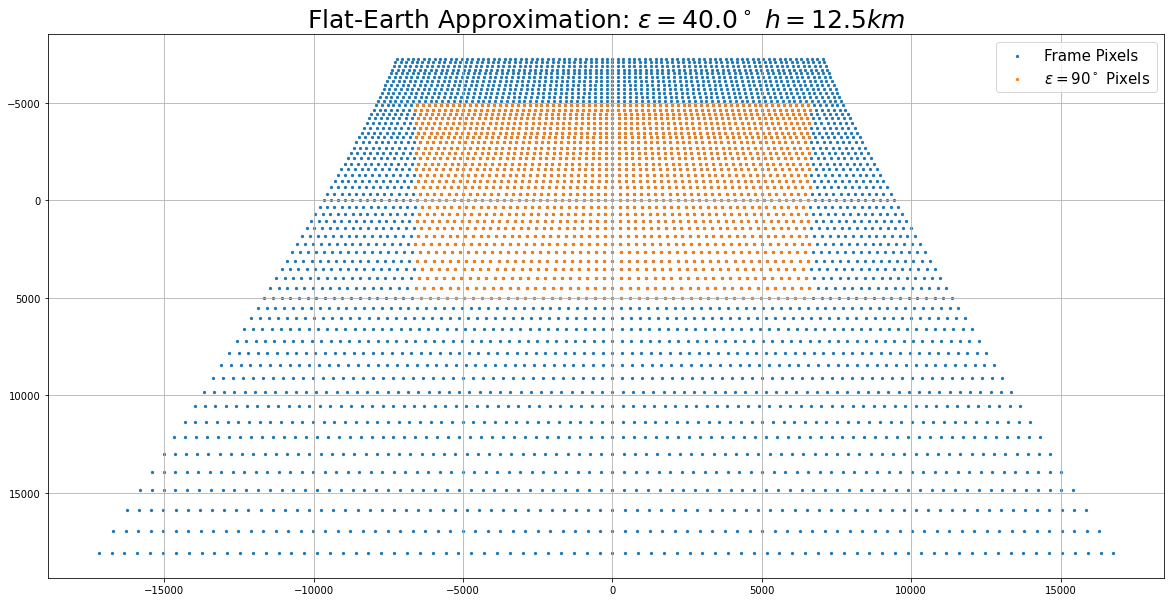

In [44]:
epsilon = 40.
height  = 12500
x_sun_  = [40, 30]
XYZ_, dXYZ_, x_, XY_interp_ = _perspective_transformation_v0(X_, Y_, N_x, N_y, x_sun_, epsilon, height)

plt.figure(figsize = (20, 10))
plt.title(r'Flat-Earth Approximation: $ \varepsilon = {}^\circ$ $h = {} km$'.format(epsilon, height/1000), 
          fontsize = 25)
plt.scatter(XYZ_[..., 0].flatten(), XYZ_[..., 1].flatten(), s = 5, label = 'Frame Pixels')
plt.scatter(XYZ_[XY_interp_[1], 0].flatten(), XYZ_[XY_interp_[1], 1].flatten(), 
            s = 5, label = r'$\varepsilon = 90^\circ$ Pixels')
plt.legend(fontsize = 15)
plt.grid()
plt.gca().invert_yaxis()
plt.show()

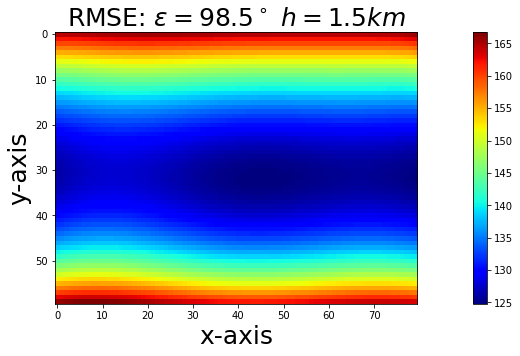

In [36]:
epsilon = 98.5
height  = 1500
x_sun_  = [40, 30]

XYZ_5_, dXYZ_5_, _, _, _, XY_interp_5_ = _perspective_transformation_v5(X_, Y_, N_x, N_y, x_sun_,
                                                                        epsilon, azimuth, latitude, 
                                                                        longitude, height)
XYZ_0_, dXYZ_0_, _, XY_interp_0_ = _perspective_transformation_v0(X_, Y_, N_x, N_y, x_sun_, epsilon, height)

E_x_ = (XYZ_5_[..., 0] - XYZ_0_[..., 0])**2
E_y_ = (XYZ_5_[..., 1] - XYZ_0_[..., 1])**2

plt.figure(figsize = (20, 5))
plt.title(r'RMSE: $ \varepsilon = {}^\circ$ $h = {} km$'.format(epsilon, height/1000), fontsize = 25)
plt.imshow(np.sqrt((E_x_ + E_y_)/2.), cmap = 'jet')
plt.xlabel('x-axis', fontsize = 25)
plt.ylabel('y-axis', fontsize = 25)
plt.colorbar()
plt.show()